## LAB 5 - TASK 3 Optional exercise submission. ML 2023-24.
**DQN**


FILL UP THIS BOX WITH YOUR DETAILS

**NAME(s) AND NIP(s)**: Andrés Martínez Silva - 904843, Luis Calderón Robustillo - 896238


This Colab is built from the official Tensorflow documentation and examples, in particular, from https://www.tensorflow.org/agents/tutorials/0_intro_rl

##### Copyright 2023 The TF-Agents Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Train a Deep Q Network with TF-Agents

## Introduction


### **Question 3.3**
** **NOT REQUIRED for the LAB (it is one of the possible optional points that you can run)**: **

Train this *tutorial* for a different environment than the `cart-pole` used in this example (careful not to pick an environment that requires much training if you depend on Colab GPU ...)

**To implement these changes, please SAVE a copy of this COLAB and name it LAB5_DRL_OPTIONAL.ipynb**

The environment used is the Atari Pong game where we train a Deep Q network based on a Convolutional Neuronal Network. Training this agent involves taking a set of preprocessed frames from the emulator as input (observation), and the output are the Q-values corresponding to the different actions the agent can take. Training this agent is computationally much more expensive than the CartPole example, and it takes much more time and resources to train the agent to actually win the game. Due to Colab's GPU restrictions, we were not able to get the agent to this point, however in the video results it can be seen that the agent manages to score a few points and keep up a bit againsts the rival for a bit, which is good enough for this reduced implementation.

## Setup

If you haven't installed the following dependencies, run:

In [1]:
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [634 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,046 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,326 kB]
Get:9 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 

In [2]:
# to run atari environments install the following:
!pip install gym[atari]
!pip install gym[accept-rom-license]
!pip install gym==0.22.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 7.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.6.1-py3-none-any.whl size=446660 sha256=e47c4c01c84a6647cfd4207a795dc976273f9adde4e39c9d77c78b524d027cfa
  Stored in directory: /root/.cache/pip/wheels/6b/1b/ef/a43ff1a2f1736d5711faa1ba4c1f61be1131b8899e6a057811
Successfully built AutoROM.accept-rom-license
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.1/631.1 kB 7.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.22.0-py3-none-any.whl size=708363 sha256=d037976c12b8117dfcff02bf45909a32c25b6ef42bf53292a3090b0e908aba2

In [16]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from tf_agents.networks.q_network import QNetwork

In [4]:
# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

## Hyperparameters

In [5]:
#num_iterations = 20000 # @param {type:"integer"}
num_iterations = 40000 # @param {type:"integer"}

initial_collect_steps = 2000  # @param {type:"integer"}
collect_steps_per_iteration =   4# @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 500  # @param {type:"integer"}

num_eval_episodes = 5  # @param {type:"integer"}
eval_interval = 5000  # @param {type:"integer"}

max_episode_frames = 108000 # @param {type:"integer"}

## Environment

In Reinforcement Learning (RL), an environment represents the task or problem to be solved. Standard environments can be created in TF-Agents using `tf_agents.environments` suites. TF-Agents has suites for loading environments from sources such as the OpenAI Gym, Atari, and DM Control.

Load the Pong environment from the OpenAI Gym suite.

In [6]:
from tf_agents.environments.atari_preprocessing import AtariPreprocessing
from tf_agents.environments.atari_wrappers import FrameStack4

env_name = 'ALE/Pong-v5'
# there are more environments here: https://www.gymlibrary.dev/environments
# but not all of them are suitable for this tutorial code (nor available in tf-Agents)
env = suite_gym.load(env_name, max_episode_steps=max_episode_frames/4, gym_env_wrappers=[AtariPreprocessing, FrameStack4])


In [7]:
# to store videos during training make sure to use gym==0.22.0
# or this wrapper doesnt work properly
# !pip instal gym==0.22.0
# env = gym.wrappers.RecordEpisodeStatistics(env)
# env = gym.wrappers.RecordVideo(env, f"videos/{gym.__version__}")

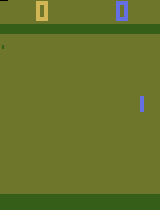

In [8]:
env.reset()
PIL.Image.fromarray(env.render())

The `environment.step` method takes an `action` in the environment and returns a `TimeStep` tuple containing the next observation of the environment and the reward for the action.

The `time_step_spec()` method returns the specification for the `TimeStep` tuple. Its `observation` attribute shows the shape of observations, the data types, and the ranges of allowed values. The `reward` attribute shows the same details for the reward.


In [9]:
print('Observation Spec:')
print(env.time_step_spec().observation)

Observation Spec:
BoundedArraySpec(shape=(84, 84, 4), dtype=dtype('uint8'), name='observation', minimum=0, maximum=255)


In [10]:
print('Reward Spec:')
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


The `action_spec()` method returns the shape, data types, and allowed values of valid actions.

In [11]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=5)


In the Pong environment:

-   `observation` is an RGB image corresponding to the current frame that is shown to the player in the screen.
-   `reward` is a scalar float value representing the score.
-   `action` is a scalar integer with six possible values:
    -   `0` — "NOOP"
    -   `1` — "FIRE"
    -   `2` — "RIGHT"
    -   `3` — "LEFT"
    -   `4` — "RIGHTFIRE"
    -   `5` — "LEFTFIRE"


In [12]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(
{'step_type': array(0, dtype=int32),
 'reward': array(0., dtype=float32),
 'discount': array(1., dtype=float32),
 'observation': array([[[ 64,  64,  64,  64],
        [ 64,  64,  64,  64],
        [ 64,  64,  64,  64],
        ...,
        [107, 107, 107, 107],
        [107, 107, 107, 107],
        [107, 107, 107, 107]],

       [[107, 107, 107, 107],
        [107, 107, 107, 107],
        [107, 107, 107, 107],
        ...,
        [107, 107, 107, 107],
        [107, 107, 107, 107],
        [107, 107, 107, 107]],

       [[107, 107, 107, 107],
        [107, 107, 107, 107],
        [107, 107, 107, 107],
        ...,
        [107, 107, 107, 107],
        [107, 107, 107, 107],
        [107, 107, 107, 107]],

       ...,

       [[ 74,  74,  74,  74],
        [ 74,  74,  74,  74],
        [ 74,  74,  74,  74],
        ...,
        [ 74,  74,  74,  74],
        [ 74,  74,  74,  74],
        [ 74,  74,  74,  74]],

       [[ 74,  74,  74,  74],
        [ 74,  74,  74,  74

Usually two environments are instantiated: one for training and one for evaluation.

In [13]:
train_py_env = suite_gym.load( #for training
    env_name,
    max_episode_steps=max_episode_frames/4,
    gym_env_wrappers=[AtariPreprocessing, FrameStack4])
eval_py_env = suite_gym.load( #for evaluation
    env_name,
    max_episode_steps=max_episode_frames/4,
    gym_env_wrappers=[AtariPreprocessing, FrameStack4])

In [14]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## Agent

The algorithm used to solve an RL problem is represented by an `Agent`. TF-Agents provides standard implementations of a variety of `Agents`. This tutorial is using the  [DQN agent](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf) (used in this tutorial)

The DQN agent can be used in any environment which has a **discrete action space**.

At the heart of a DQN Agent is a `QNetwork`, a neural network model that can learn to predict `QValues` (expected returns) for all actions, given an observation from the environment.

We will use `tf_agents.networks.` to create a `QNetwork`. The network will consist of CNN, where the final layer will have 1 output for each possible action.

In [17]:
#
# Q-Network, DQN
preprocessing_layer = tf.keras.layers.Lambda(lambda obs: tf.cast(obs, np.float32)/255.)
# list of convolution layers parameters: Each item is a length-three tuple
# indicating (filters, kernel_size, stride):
conv_layer_params=[(32, (8, 8), 4), (64, (4, 4), 2), (64, (3, 3), 1)]
fc_layer_params=[512]
q_net = QNetwork(
    input_tensor_spec=    train_env.observation_spec(),
    action_spec=          train_env.action_spec(),
    preprocessing_layers= preprocessing_layer,
    conv_layer_params=    conv_layer_params,
    fc_layer_params=      fc_layer_params)

Now use `tf_agents.agents.dqn.dqn_agent` to instantiate a `DqnAgent`. In addition to the `time_step_spec`, `action_spec` and the QNetwork, the agent constructor also requires an optimizer (in this case, `AdamOptimizer`), a loss function, and an integer step counter.

In [18]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)


epsilon_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=1.0,
    decay_steps=150_000//collect_steps_per_iteration,
    end_learning_rate=0.01)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    target_update_period = 2000,
    td_errors_loss_fn=common.element_wise_squared_loss,
    gamma = 0.99,
    train_step_counter=train_step_counter,
    epsilon_greedy= lambda: epsilon_fn(train_step_counter)
)

agent.initialize()

In [19]:
q_net.summary()

Model: "QNetwork"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EncodingNetwork (EncodingN  multiple                  1684128   
 etwork)                                                         
                                                                 
 dense_1 (Dense)             multiple                  3078      
                                                                 
Total params: 1687206 (6.44 MB)
Trainable params: 1687206 (6.44 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Metrics and Evaluation

The most common metric used to evaluate a policy is the average return. The return is the sum of rewards obtained while running a policy in an environment for an episode. Several episodes are run, creating an average return.

The following function computes the average return of a policy, given the policy, environment, and a number of episodes.


In [20]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

train_metrics = [
    tf_metrics.NumberOfEpisodes(),
    tf_metrics.EnvironmentSteps(),
    tf_metrics.AverageReturnMetric(),
    tf_metrics.AverageEpisodeLengthMetric(),
]

## Replay Buffer

In [21]:
from tf_agents.replay_buffers import tf_uniform_replay_buffer

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=  agent.collect_data_spec,
    batch_size= train_env.batch_size,
    max_length= replay_buffer_max_length)
replay_buffer_observer = replay_buffer.add_batch

For most agents, `collect_data_spec` is a named tuple called `Trajectory`, containing the specs for observations, actions, rewards, and other items.

In [22]:
agent.collect_data_spec

Trajectory(
{'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(84, 84, 4), dtype=tf.uint8, name='observation', minimum=array(0, dtype=uint8), maximum=array(255, dtype=uint8)),
 'action': BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(5)),
 'policy_info': (),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32))})

In [23]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

## Data Collection

Now execute the random policy in the environment for a few steps, recording the data in the replay buffer.


In [24]:
from tf_agents.drivers.dynamic_step_driver import DynamicStepDriver
from tf_agents.policies.random_tf_policy import RandomTFPolicy

class Progress: #class to show progress
    def __init__(self, total):
        self.counter = 0
        self.total = total
    def __call__(self, trajectory):
        if not trajectory.is_boundary():
            self.counter += 1
        if self.counter % 100 == 0:
            print("\r{}/{}".format(self.counter, self.total), end="")

initial_collect_policy = RandomTFPolicy(train_env.time_step_spec(),
                                        train_env.action_spec())
init_driver = DynamicStepDriver(
    env=       train_env,
    policy=    initial_collect_policy,
    observers= [replay_buffer.add_batch, Progress(initial_collect_steps)],
    num_steps= initial_collect_steps
    )
final_time_step, final_policy_state = init_driver.run()

2000/2000

The replay buffer is now a collection of Trajectories.

The agent needs access to the replay buffer. This is provided by creating an iterable `tf.data.Dataset` pipeline which will feed data to the agent.

Each row of the replay buffer only stores a single observation step. But since the DQN Agent needs both the current and next observation to compute the loss, the dataset pipeline will sample two adjacent rows for each item in the batch (`num_steps=2`).

This dataset is also optimized by running parallel calls and prefetching data.

In [25]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

dataset

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


<_PrefetchDataset element_spec=(Trajectory(
{'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(64, 2, 84, 84, 4), dtype=tf.uint8, name=None),
 'action': TensorSpec(shape=(64, 2), dtype=tf.int64, name=None),
 'policy_info': (),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None)}), BufferInfo(ids=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), probabilities=TensorSpec(shape=(64,), dtype=tf.float32, name=None)))>

In [26]:
iterator = iter(dataset)

## Training the agent

Two things must happen during the training loop:

-   collect data from the environment
-   use that data to train the agent's neural network(s)

This example also periodicially evaluates the policy and prints the current score.

In [27]:
try:
  %%time
except:
  pass

policy_state = agent.collect_policy.get_initial_state(train_env.batch_size)

collect_driver = DynamicStepDriver(
    env=       train_env,
    policy=    agent.collect_policy,
    observers= [replay_buffer_observer] + train_metrics,
    num_steps= collect_steps_per_iteration)

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)
collect_driver.run = common.function(collect_driver.run)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = None

for _ in range(num_iterations):

  # Collect a few steps and save to the replay buffer.
  time_step, policy_state = collect_driver.run(time_step, policy_state)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


step = 500: loss = 0.0152976643294096
step = 1000: loss = 0.016052911058068275
step = 1500: loss = 0.007428515702486038
step = 2000: loss = 0.003179804654791951
step = 2500: loss = 0.02883644588291645
step = 3000: loss = 0.015829553827643394
step = 3500: loss = 0.014283470809459686
step = 4000: loss = 0.007837029173970222
step = 4500: loss = 0.017188509926199913
step = 5000: loss = 0.006149508524686098
step = 5000: Average Return = -20.799999237060547
step = 5500: loss = 0.005646848119795322
step = 6000: loss = 0.004455910995602608
step = 6500: loss = 0.009210927411913872
step = 7000: loss = 0.003973891027271748
step = 7500: loss = 0.011735725216567516
step = 8000: loss = 0.008926881477236748
step = 8500: loss = 0.03412366658449173
step = 9000: loss = 0.007863590493798256
step = 9500: loss = 0.004168935120105743
step = 10000: loss = 0.014445265755057335
step = 10000: Average Return = -19.399999618530273
step = 10500: loss = 0.022014550864696503
step = 11000: loss = 0.007661640644073486

## Visualization


### Plots

Use `matplotlib.pyplot` to chart how the policy improved during training.

One iteration of `ALE/Pong-v5` consists of 500 time steps. The environment rewards score points for getting the ball to pass the opponent's paddle, and takes away points if the ball passes the agent's paddle. The charts shows the return increasing towards that maximum each time it is evaluated during training. (It may be a little unstable and not increase monotonically each time.)

(-21.4, 50.0)

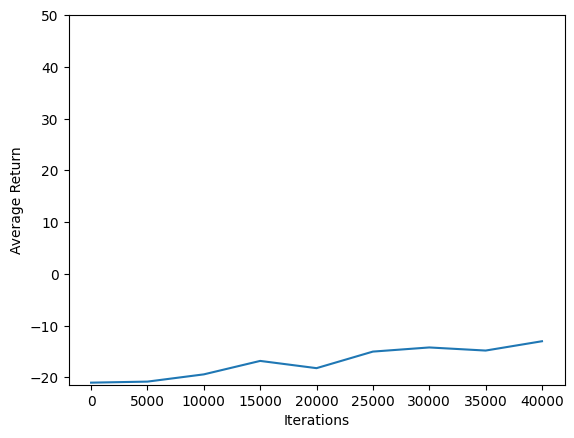

In [28]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=50)

### Videos

Charts are nice. But more exciting is seeing an agent actually performing a task in an environment.

First, create a function to embed videos in the notebook.

In [29]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

Now iterate through a few episodes of the Pong game with the agent. The underlying Python environment (the one "inside" the TensorFlow environment wrapper) provides a `render()` method, which outputs an image of the environment state. These can be collected into a video.

In [30]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

In [31]:
# create a video for your agent version
create_policy_eval_video(agent.policy, "trained-agent")

In [ ]:
# create a video for a random agent
create_policy_eval_video(random_policy, "random-agent")